# Petri Dish Analysis: Disks and Inhibition Zones

### Cell 1: Setup and Imports

This cell imports all the necessary libraries (`OpenCV`, `Numpy`, `Matplotlib`) and defines a helper function we'll use to display images in the notebook.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_images(images, titles):
    """
    Helper function to display multiple images side-by-side in a Jupyter Notebook.
    """
    # Create a figure to hold the images
    plt.figure(figsize=(15, 7))
    
    # Loop through each image and title
    for i, (image, title) in enumerate(zip(images, titles)):
        # Convert BGR (OpenCV's default) to RGB (Matplotlib's default)
        if len(image.shape) == 3:
            image_to_show = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image_to_show = image # It's already grayscale
        
        # Create a subplot for each image
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image_to_show, cmap='gray' if len(image_to_show.shape) == 2 else None)
        plt.title(title)
        plt.axis('off')
    
    # Show the plot
    plt.show()

print("Libraries imported and helper function defined.")

Libraries imported and helper function defined.


### Cell 2: Load and Pre-process Image

This cell loads your original image from the disk. It then creates two versions in memory:
1.  `img_gray`: A grayscale version used for pixel-level analysis.
2.  `img_blurred`: A blurred grayscale version, which is the best input for `HoughCircles` as it reduces noise.

Image loaded and pre-processed successfully.


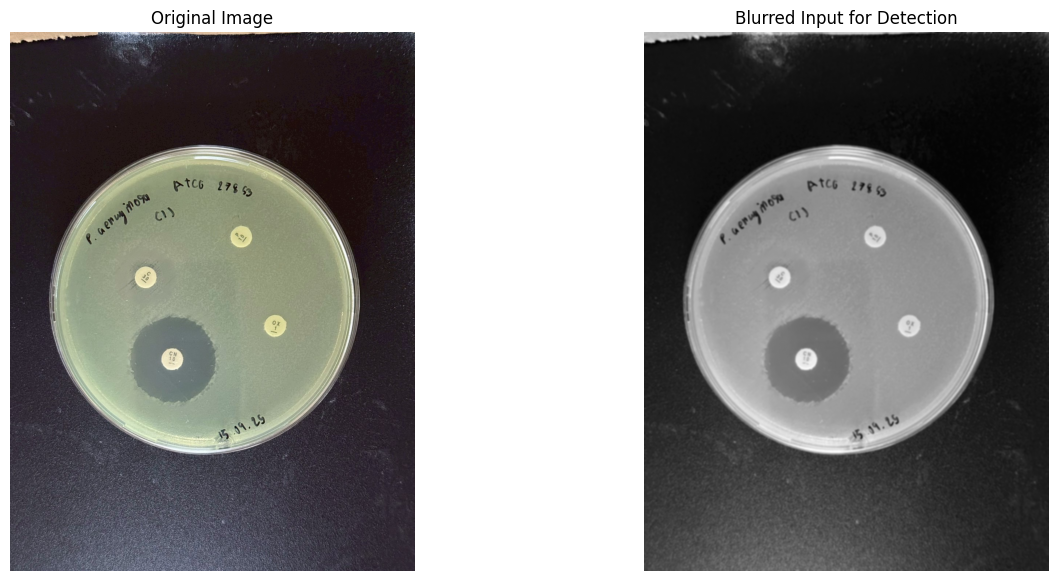

In [3]:
# --- Configuration ---
image_path = 'best/20250919_033735892_iOS.jpg' # Path to your example image
# ---------------------

try:
    # Load the original image (in color)
    img_original = cv2.imread(image_path)
    if img_original is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    # Create the grayscale version
    img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
    
    # Create the blurred version for Hough Transform
    img_blurred = cv2.GaussianBlur(img_gray, (9, 9), 2)
    
    print("Image loaded and pre-processed successfully.")
    
    # Display the inputs we'll use
    display_images(
        [img_original, img_blurred],
        ['Original Image', 'Blurred Input for Detection']
    )

except FileNotFoundError as e:
    print(e)

### Cell 3: (Visualization) Sigmoid & Otsu Binarization

This cell creates the high-contrast Sigmoid and Otsu images you requested for visualization. 

**Note:** These images are for viewing only. The following steps will use the `img_blurred` and `img_gray` from Cell 2 for detection, as they are more reliable.

Sigmoid and Otsu images created for visualization.


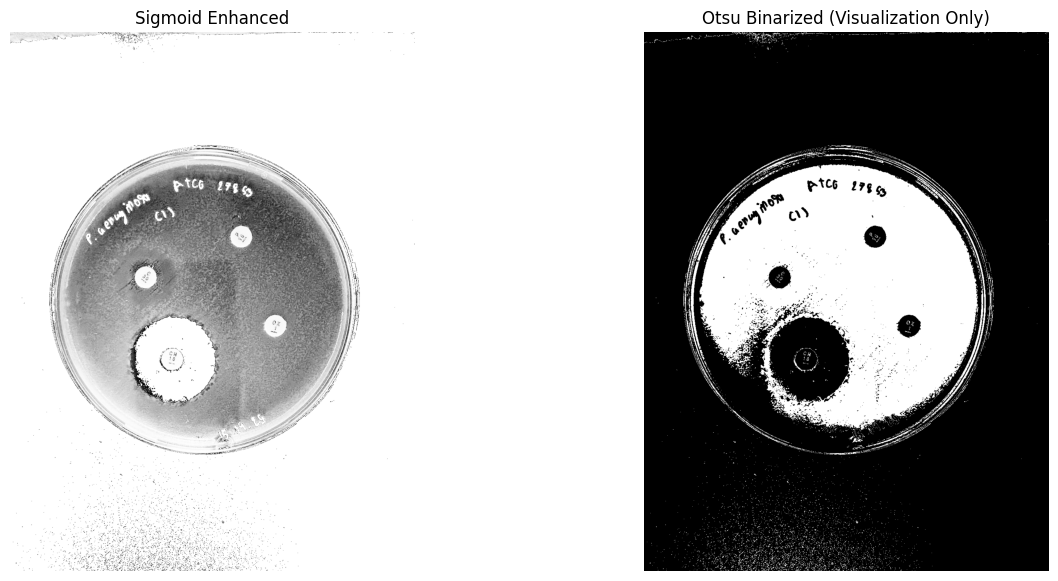

In [4]:
# --- Create Sigmoid Image ---
# Use the grayscale image from Cell 2
gain = 0.05 
img_normalized = (img_gray - 128) * gain
img_sigmoid = 1 / (1 + np.exp(-img_normalized))
img_sigmoid_enhanced = (img_sigmoid * 255).astype(np.uint8)

# --- Create Otsu Image ---
ret, img_otsu = cv2.threshold(
    img_sigmoid_enhanced, 
    0, 
    255, 
    cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)

print("Sigmoid and Otsu images created for visualization.")

# Display the high-contrast images
display_images(
    [img_sigmoid_enhanced, img_otsu],
    ['Sigmoid Enhanced', 'Otsu Binarized (Visualization Only)']
)

### Cell 4: Step 1 - Find SMALL Medicine Disks

This cell runs the first detection pass to find *only* the small medicine disks. It uses `img_blurred` as its input. You can re-run this cell, adjusting the parameters until it looks perfect. The results are stored in the `disk_circles` variable.

Found 4 medicine disk(s).


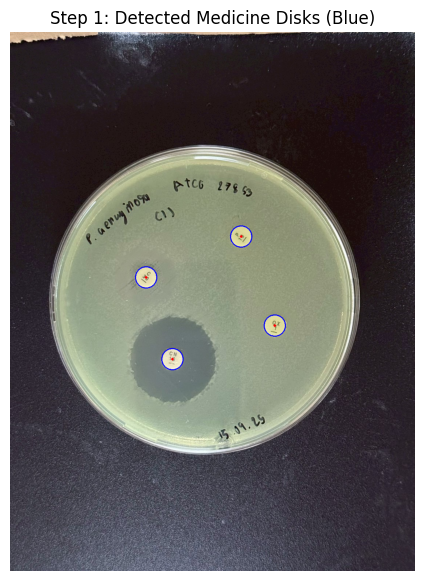

In [5]:
# --- Customize Disk Detection Parameters ---
disk_minDist = 40
disk_param2 = 30     # Threshold for detection. Lower = more sensitive.
disk_minRadius = 15  # Smallest disk radius to look for
disk_maxRadius = 30  # Largest disk radius to look for
# -----------------------------------------

# Find the disk circles using the blurred image
disk_circles = cv2.HoughCircles(
    image=img_blurred,
    method=cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=disk_minDist,
    param1=50,
    param2=disk_param2,
    minRadius=disk_minRadius,
    maxRadius=disk_maxRadius
)

# Create a copy of the original to draw on
img_with_disks = img_original.copy()

if disk_circles is not None:
    disk_circles = np.uint16(np.around(disk_circles))
    print(f"Found {len(disk_circles[0])} medicine disk(s).")
    
    # Draw the detected disks
    for i in disk_circles[0, :]:
        center = (i[0], i[1])
        radius = i[2]
        cv2.circle(img_with_disks, center, 2, (0, 0, 255), 3)       # Red center
        cv2.circle(img_with_disks, center, radius, (255, 0, 0), 2)  # Blue outline
else:
    print("No medicine disks found. Try adjusting parameters.")

# Show the picture for THIS step
display_images([img_with_disks], ['Step 1: Detected Medicine Disks (Blue)'])

### Cell 5: Step 2 - Find Zone Radius by Projecting from Disk Center

This is the advanced step. It takes the `disk_circles` from the cell above and the `img_gray` from Cell 2. It loops through each found disk, checks if it's in a dark zone, and if so, scans outward to measure the radius until it hits the bright bacterial lawn. The results are stored in `zone_measurements`.

In [ ]:
# --- Configuration ---
SCAN_DIRECTIONS = 8 # Number of directions to scan (8 = up, down, left, right, and diagonals)
MAX_SCAN_RADIUS = 250 # How far out to scan from the center (in pixels)
EDGE_THRESHOLD = 50 # The pixel intensity "jump" that defines an edge.
ZONE_DARKNESS_THRESHOLD = 100 # How dark a spot must be to be considered a 'zone'
# ---------------------

zone_measurements = []

if disk_circles is not None:
    print("Step 2: Analyzing pixel intensity around each disk...")
    
    for disk in disk_circles[0, :]:
        center_x, center_y, disk_radius = disk
        center = (center_x, center_y)
        
        # 1. Check if this disk is in an inhibition zone
        ring_radius = disk_radius + 15
        try:
            # Simple check at 4 points in the ring
            points = [
                img_gray[center_y + ring_radius, center_x], # Bottom
                img_gray[center_y - ring_radius, center_x], # Top
                img_gray[center_y, center_x + ring_radius], # Right
                img_gray[center_y, center_x - ring_radius]  # Left
            ]
            avg_intensity = np.mean(points)
        except IndexError:
            # This happens if the disk is too close to the edge of the image
            avg_intensity = 255 # Assume it's not in a zone
            
        # A low intensity (dark) means it's in a clear zone. 
        if avg_intensity < ZONE_DARKNESS_THRESHOLD:
            print(f"  -> Disk at {center} is in a dark zone! Measuring radius...")
            measured_radii = []
            
            # 2. Scan outwards in 8 directions
            for i in range(SCAN_DIRECTIONS):
                angle = (i / SCAN_DIRECTIONS) * 2 * np.pi
                cos_a = np.cos(angle)
                sin_a = np.sin(angle)
                
                # Get the pixel intensity value *just* outside the disk
                start_r = disk_radius + 5
                start_x = int(center_x + start_r * cos_a)
                start_y = int(center_y + start_r * sin_a)
                try:
                    base_intensity = int(img_gray[start_y, start_x])
                except IndexError:
                    continue # Skip this angle if it's off-image
                
                # 3. Find the edge
                # Scan from the disk edge outwards
                for r in range(start_r, MAX_SCAN_RADIUS):
                    current_x = int(center_x + r * cos_a)
                    current_y = int(center_y + r * sin_a)
                    
                    try:
                        current_intensity = int(img_gray[current_y, current_x])
                    except IndexError:
                        break # Stop if we go off the image
                    
                    # Look for a sudden jump in brightness (dark zone -> light lawn)
                    if current_intensity - base_intensity > EDGE_THRESHOLD:
                        # We found the edge!
                        measured_radii.append(r)
                        break # Stop scanning this direction
            
            # 4. Average the results
            if measured_radii:
                avg_radius = int(np.mean(measured_radii))
                print(f"  -> Average measured radius: {avg_radius} pixels")
                zone_measurements.append({'center': center, 'radius': avg_radius})
            else:
                print("  -> Could not find a clear edge for this zone.")
else:
    print("Step 2: No disks found to measure from.")

Step 2: Analyzing pixel intensity around each disk...


### Cell 6: Step 3 - Draw and Display Final Results

This final cell combines all the results. It takes the `disk_circles` from Cell 4 and the `zone_measurements` from Cell 5 and draws them together on a fresh copy of the original image.

--- Final Combined Report ---
Found 4 Medicine Disks (Blue)
No inhibition zones were measured.


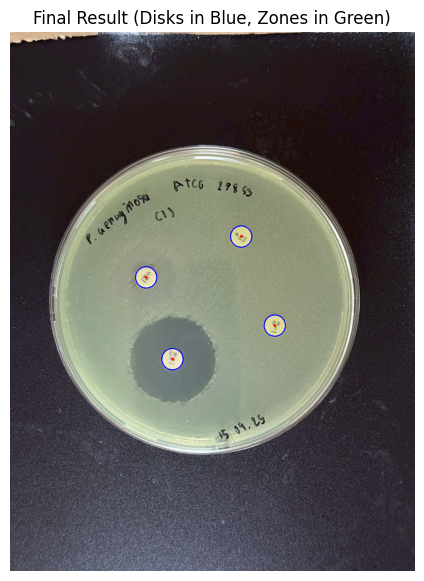

In [7]:
# Create a fresh copy of the original image to draw the combined result
img_with_all_circles = img_original.copy()

print("--- Final Combined Report ---")

# Draw the medicine disks (from Cell 4) in BLUE
if disk_circles is not None:
    for i in disk_circles[0, :]:
        center = (i[0], i[1])
        radius = i[2]
        cv2.circle(img_with_all_circles, center, 2, (0, 0, 255), 3)       # Red center
        cv2.circle(img_with_all_circles, center, radius, (255, 0, 0), 2)  # Blue outline
    print(f"Found {len(disk_circles[0])} Medicine Disks (Blue)")

# Draw the inhibition zones (from Cell 5) in GREEN
if zone_measurements:
    print(f"Found {len(zone_measurements)} Inhibition Zone(s) (Green)")
    for zone in zone_measurements:
        center = zone['center']
        radius = zone['radius']
        cv2.circle(img_with_all_circles, center, radius, (0, 255, 0), 4) # Green outline
        print(f"  - Zone at {center}, Radius: {radius} pixels") # Print the radius as requested
else:
    print("No inhibition zones were measured.")

# Display the final, combined image
display_images(
    [img_with_all_circles],
    ['Final Result (Disks in Blue, Zones in Green)']
)